## Decision Trees

### Regression tree


#### Lab: Regression tree
Fit a regression tree to the **Boston** data. 


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "lstat" "rm"    "dis"  
Number of terminal nodes:  8 
Residual mean deviance:  12.65 = 3099 / 245 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-14.10000  -2.04200  -0.05357   0.00000   1.96000  12.60000 

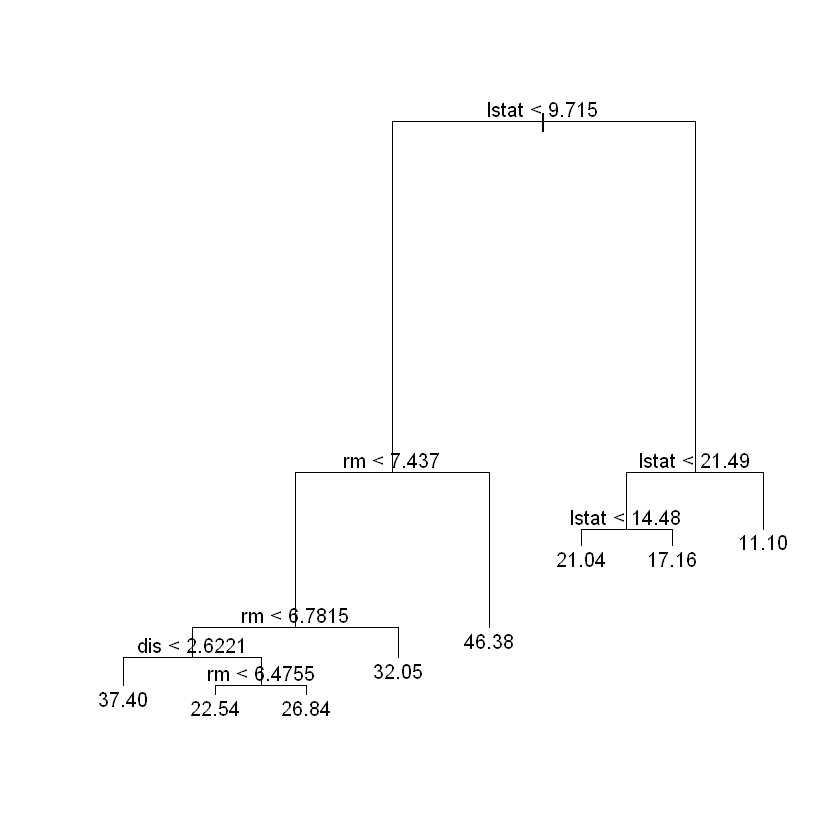

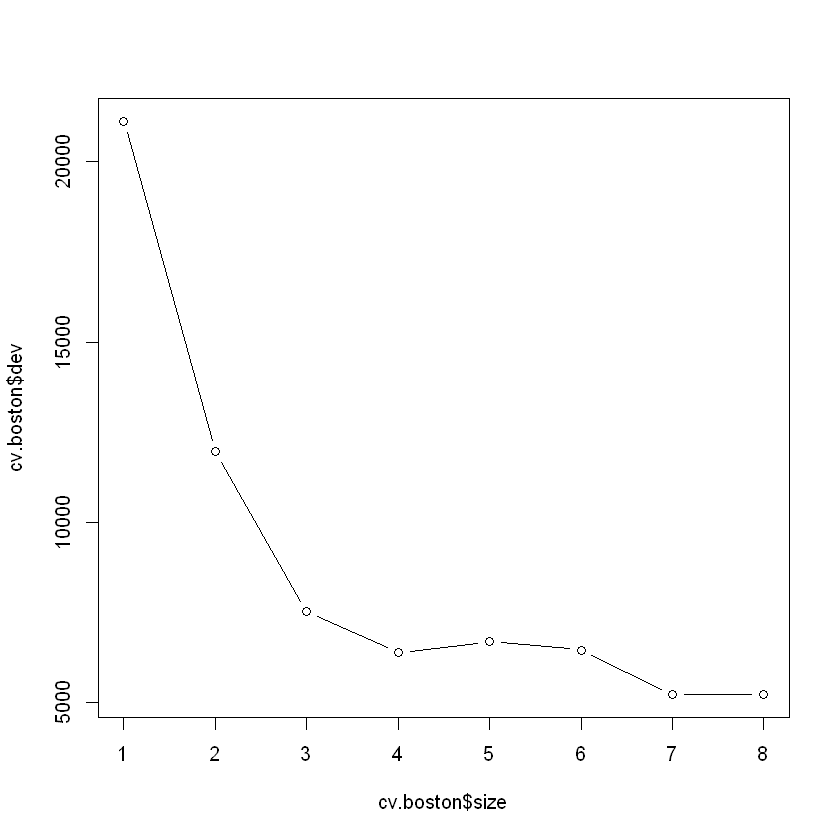

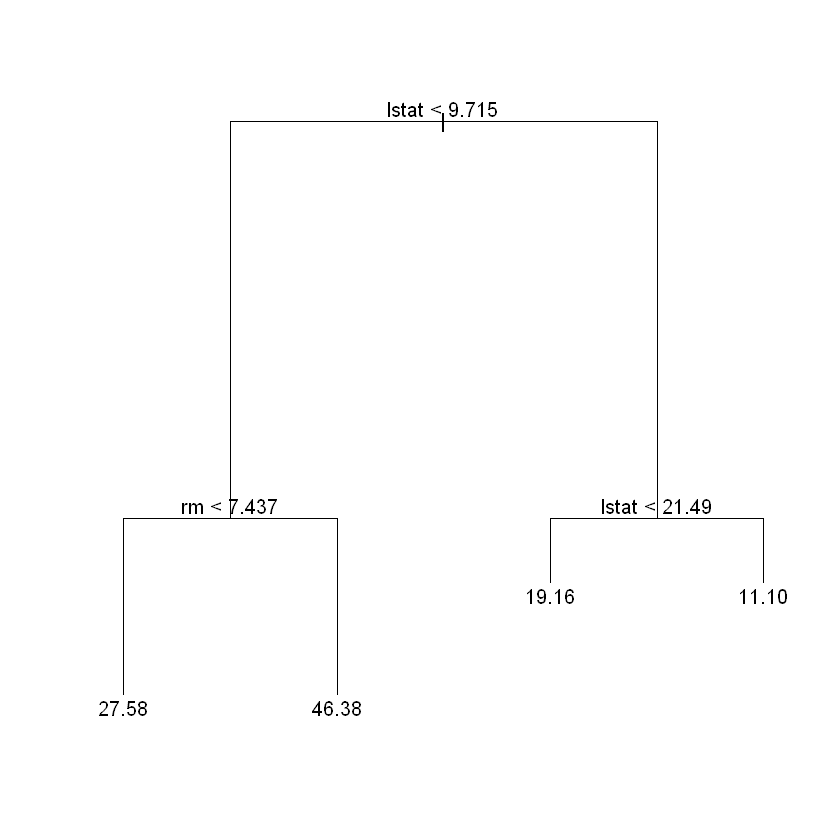

In [26]:
library(MASS)
library(tree)
set.seed(1)
#names(Boston)
train = sample(1:nrow(Boston), nrow(Boston)/2)
tree.boston = tree(medv~., Boston, subset=train) #只用training set
summary(tree.boston)
plot(tree.boston) # 画出树，没有标记
text(tree.boston, pretty=0)  # 做标记

# 使用 cv.tree()做CV分析
cv.boston = cv.tree(tree.boston)
plot(cv.boston$size, cv.boston$dev, type='b')

# 使用 prune.tree()做树修建
prune.boston = prune.tree(tree.boston, best=4) #返回修剪过的树， best控制terminal node个数
plot(prune.boston)
text(prune.boston, pretty=0)


使用predict可以直接做预测：

[1] 25.04559

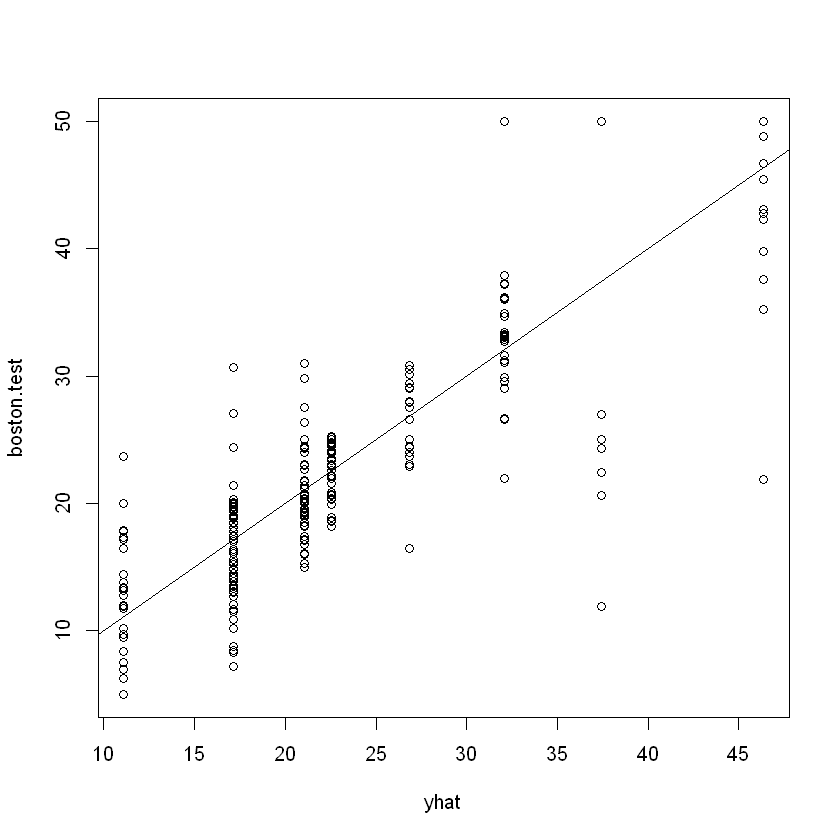

In [25]:
yhat = predict(tree.boston, newdata=Boston[-train,])
#yhat
boston.test = Boston[-train,"medv"]
plot(yhat, boston.test)
abline(0,1)
#计算MSE
mean((yhat-boston.test)^2)

### Classification tree

与regression tree过程类似。但是决定如何进一步分割每个叶子节点的时候使用的指标不再是RSS，即：
$$
\sum_{j=1}^J\sum_{i\in R_j}(y_i - y_{R_j})^2
$$
比较合理的指标应该能够刻画observation落在分割之后的区域里面的

In [10]:
library(tree)

In [11]:
library(ISLR)
attach(Carseats)
High=ifelse(Sales<=8, "NO", "YES") # 把量化数据转换成描述性数据。
Carseats=data.frame(Carseats, High)

In [12]:
tree.carseats=tree(High~.-Sales, Carseats)
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

### Bagging, Random Forests, Boosting

这三个方法都可以进一步提高决策树的预测能力。其中的Bagging和Boosting两种方法都不只是能用来决策树，它们也是提高其它统计学习方法的重要技术。

#### Bagging
这个方法是用来减小统计学习方法的variance的通用技术，它在决策树里面尤其有用。简单的决策树做出的模型variance很大，这意味着我们划分training set和testingset时随机的划分方式对最后的结果影响很大。换一种划分方式，预测结果可能差得十万八千里。Bagging方法的具体做法是使用**Booststrap**从已有数据集里面重复采样，弄出B组training set来，然后用每一组training set可以构建一个决策树（足够深且不修剪），这所有的决策树的平均就是最终的决策树模型。对于量化的response(对应回归树)其形式化表述为：
$$
\hat f_\text{bag}(x) = \frac{1}{B}\sum_{b=1}^{B}\hat f^{*b}(x)
$$

而对于qualitative的response（对应分类树），则简单的采用**少数服从多数原则**的多数票制。对于Bagging而言，这个B的具体大小并不关键，即使用很大的B，也不会导致overfitting。通常使用足够大的B，使得test error不再随着B的增大而显著增大。

#### Out-Of-Bag 误差估计
估计bagged model的test error的方法相当简单，并不需要像之前学习的模型那样使用CV或者Validation set方法。可以证明，在使用Bagging构建每一个决策树时，平均只会用到2/3的数据。对于一个给定的树，在构建它的时候没有用到的observation称其为out-of-bag (OOB) observation。 对任意第i个observation，可以使用那些没有用到它的决策树来做预测。因此平均而言，对这个observation,可以产生B/3个预测。换句话说，对于任意指定的observation，它平均是B/3个数的OOB observation。把这（平均）B/3个树预测此observation的结果做平均（或者使用投票方法）就可以得到整体树模型在对这个数据的预测。对所有的observation都来一篇这种预测，总体的OOB test MS（对决策树而言）或者classification error（对分类树）就可以求出。

#### 衡量predictor的重要性
简单的决策树的好处是模型很容易被解释，但是用上Bagging之后，模型的可理解性就变得很差了，因为实际预测结果是混合了很多不同的树预测结果。尽管如此，对于Bagging得到的tree, 我们还是可以从总体上得出各个predictor的重要性（相对的）。比如对于回归树，为了衡量变量$x_j$对这棵树的重要性，可以计算在每一个树$f^{*,b}$中由于使用了$x_j$而导致的这个树的RSS的降低量，然后对B个数做平均，就得到了由于使用这个变量，使得总体树的RSS的减少量。对不同的$x_j (j=1,\ldots, p)$都做这种处理，就可以得到各个变量的相对重要性了。类似的，对于分类树，可以使用减少的Gini指数做为重要性的指标。

#### Random Forest
Random Forest是对Bagging方法的一种改进。引入Bagging方法，原本是为了降低模型的variance，但是如果某个predictor太**强势**(重要性很大，see above)，则那B棵树里面的绝大多数树都会在树的根部就使用这个predicotor划分，这样就造成了这B棵数里面的大部分树都长得很像。这样的话Bagging方法就不能有效的减少variance了。而Random Forest就是为了克服Bagging方法的这个问题。Random Fores具体算法只是在Bagging方法上做了微调。在确定每次划分所使用的predictor的时候，规定只能在一组（m个）随机选取的predictor中选择。每次划分都重新构造这个可选取predictor集合。通常做法是使$m\approx \sqrt{p}$。Random Forest方法可以理解为对各个树解耦，从而降低总体树的variance。

#### Boosting
Boosting和Bagging一样也是改进很多统计学习方法的一种通用方法。它也涉及到构建B棵树，但是与Bagging不同，在构建第b棵树的时候，它会使用到第b-1棵树的信息。具体的算法如下：


1. Set $\hat f(x)$ = 0, $r_i = y_i$ for all $i$ in the training set.
2. For $b = 1, 2, \ldots, B$:
    1. 使用 $(X, r)$ 作为training set， 划分$d$次构建树 $\hat{f}^b$。
    2. 更新树 $\hat f$:
        $$
        \hat f(x) \leftarrow f(x) + \lambda \hat f^b(x) 
        $$
3. 输出：
    $$
    \hat f = \sum_{b=1}^B \lambda  \hat f^b(x)
    $$
    
注意到里面有三个参数：
1. 树的棵树 $B$， 与Bagging不同，B取得太大会导致overfitting。
2. 参数 $\lambda$， 通常取0.01或者0.001（需要根据问题选取）。它控制boosting学习的速度。如果取得太小可能需要很大的B才能有好的效果。
3. 划分次数 $d$, 通常取1就很好了。